### Installing Dependencies

In [ ]:
!pip install -q kaggle


In [ ]:
!pip install torchcodec

In [ ]:
!pip install datasets transformers torchaudio torchcodec

### Dataset Preprocessing

In [ ]:
import torchcodec
print(torchcodec.__version__)


0.9.1


In [ ]:
from datasets import Audio

dataset = load_dataset("CosminMihai02/real_fake_audio")

dataset = dataset.cast_column(
    "audio",
    Audio(decode=False)
)


In [2]:
from datasets import load_dataset

dataset = load_dataset("CosminMihai02/real_fake_audio")

# Access audio
audio_sample = dataset['train'][0]['audio']
print(f"Sample rate: {audio_sample['sampling_rate']}")
print(f"Audio shape: {audio_sample['array'].shape}")


Sample rate: 16000
Audio shape: (258104100,)


In [3]:
dataset


DatasetDict({
    train: Dataset({
        features: ['audio', 'label', 'filename', 'duration'],
        num_rows: 67
    })
})

In [4]:
dataset["train"].features


{'audio': Audio(sampling_rate=None, decode=True, stream_index=None),
 'label': ClassLabel(names=['fake', 'real']),
 'filename': Value('string'),
 'duration': Value('float64')}

In [5]:
import numpy as np

def chunk_audio(audio, sr, chunk_seconds=4):
    chunk_size = sr * chunk_seconds
    chunks = []

    for i in range(0, len(audio), chunk_size):
        chunk = audio[i:i+chunk_size]
        if len(chunk) == chunk_size:
            chunks.append(chunk)

    return chunks


In [6]:
import os, soundfile as sf, random

BASE_OUT = "/content/audio_dataset"
os.makedirs(BASE_OUT, exist_ok=True)

splits = {
    "train": 800,
    "val": 100,
    "test": 100
}

for s in splits:
    for c in ["real", "fake"]:
        os.makedirs(os.path.join(BASE_OUT, s, c), exist_ok=True)


In [7]:
real_chunks = []
fake_chunks = []

for item in dataset["train"]:
    audio = item["audio"]["array"]
    sr = item["audio"]["sampling_rate"]
    label = item["label"]   # confirm this name

    chunks = chunk_audio(audio, sr)

    if label == 0:
        real_chunks.extend(chunks)
    else:
        fake_chunks.extend(chunks)


In [8]:
random.shuffle(real_chunks)
random.shuffle(fake_chunks)

real_chunks = real_chunks[:1000]
fake_chunks = fake_chunks[:1000]


In [10]:
def save_chunks(chunks, cls):
    file_idx = 0 # This index is used for both file naming and accessing elements in 'chunks'

    for split, n in splits.items():
        current_split_count = 0 # Counter for items saved in the current split

        # Iterate up to 'n' for the current split, but also ensure we don't exceed available chunks
        while current_split_count < n and file_idx < len(chunks):
            path = os.path.join(BASE_OUT, split, cls, f"{cls}_{file_idx}.wav")
            sf.write(path, chunks[file_idx], 16000)
            file_idx += 1 # Increment index for the next chunk to be saved
            current_split_count += 1

        # If we ran out of chunks entirely, break from further processing splits
        if file_idx >= len(chunks):
            break

save_chunks(real_chunks, "real")
save_chunks(fake_chunks, "fake")

In [11]:
!find /content/audio_dataset -type f | wc -l


1190


In [12]:
print("Real chunks:", len(real_chunks))
print("Fake chunks:", len(fake_chunks))


Real chunks: 190
Fake chunks: 1000


In [13]:
import os, random, numpy as np, soundfile as sf, librosa

BASE_OUT = "/content/audio_dataset"

splits = {
    "train": 800,
    "val": 100,
    "test": 100
}

for s in splits:
    for c in ["real", "fake"]:
        os.makedirs(os.path.join(BASE_OUT, s, c), exist_ok=True)


In [14]:
def chunk_audio(audio, sr, chunk_seconds=1):
    chunk_size = sr * chunk_seconds
    return [
        audio[i:i+chunk_size]
        for i in range(0, len(audio), chunk_size)
        if len(audio[i:i+chunk_size]) == chunk_size
    ]


In [21]:
def fix_length(audio, length):
    if len(audio) > length:
        return audio[:length]
    elif len(audio) < length:
        return np.pad(audio, (0, length - len(audio)))
    return audio

def augment_audio(audio, sr):
    L = len(audio)
    aug = []

    # original
    aug.append(audio)

    # noise
    aug.append(fix_length(audio + np.random.normal(0, 0.005, audio.shape), L))

    # time stretch
    aug.append(fix_length(librosa.effects.time_stretch(audio, rate=0.95), L))
    aug.append(fix_length(librosa.effects.time_stretch(audio, rate=1.05), L))

    # pitch shift (FIXED)
    aug.append(fix_length(librosa.effects.pitch_shift(audio, sr=sr, n_steps=1), L))

    return aug


In [54]:
real_chunks, fake_chunks = [], []

for item in dataset["train"]:
    audio = item["audio"]["array"]
    sr = item["audio"]["sampling_rate"]
    label = item["label"]

    chunks = chunk_audio(audio, sr, 1)

    if label == 0:  # real
        for c in chunks:
            real_chunks.extend(augment_audio(c, sr))
    else:           # fake
        fake_chunks.extend(chunks)

print("Real:", len(real_chunks), "Fake:", len(fake_chunks))

Real: 4260 Fake: 31365


In [23]:
import random

random.shuffle(real_chunks)
random.shuffle(fake_chunks)

real_chunks = real_chunks[:2000]
fake_chunks = fake_chunks[:2000]


In [24]:
def save_chunks(chunks, cls):
    idx = 0
    for split, n in splits.items():
        count = 0
        while count < n and idx < len(chunks):
            path = os.path.join(BASE_OUT, split, cls, f"{cls}_{idx}.wav")
            sf.write(path, chunks[idx], 16000)
            idx += 1
            count += 1

save_chunks(real_chunks, "real")
save_chunks(fake_chunks, "fake")


In [25]:
!find /content/audio_dataset -type f | wc -l


2000


In [26]:
!ls /content/audio_dataset/train/real | wc -l

800


In [27]:
!ls /content/audio_dataset/train/fake | wc -l

800


### Creating Embeddings [wav2vec]

In [28]:
!pip install -q transformers torchaudio


In [29]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

wav2vec.to(device)
wav2vec.eval()

# Freeze wav2vec
for param in wav2vec.parameters():
    param.requires_grad = False

print("wav2vec loaded & frozen ✅")


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

wav2vec loaded & frozen ✅


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [30]:
import torchaudio

def load_audio(path):
    waveform, sr = torchaudio.load(path)

    # mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # resample if needed
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, sr, 16000)

    return waveform.squeeze()


In [31]:
def extract_wav2vec_embedding(wav_path):
    audio = load_audio(wav_path)

    inputs = processor(
        audio,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = wav2vec(
            inputs.input_values.to(device)
        )

    # shape: (T, 768)
    embedding = outputs.last_hidden_state.squeeze(0).cpu().numpy()
    return embedding


In [32]:
BASE_AUDIO = "/content/audio_dataset"
BASE_EMB   = "/content/embeddings"

splits = ["train", "val", "test"]
classes = ["real", "fake"]

import os

for s in splits:
    for c in classes:
        os.makedirs(os.path.join(BASE_EMB, s, c), exist_ok=True)


In [33]:
import numpy as np
from tqdm import tqdm

for split in splits:
    for cls in classes:
        audio_dir = os.path.join(BASE_AUDIO, split, cls)
        emb_dir   = os.path.join(BASE_EMB, split, cls)

        for fname in tqdm(os.listdir(audio_dir), desc=f"{split}/{cls}"):
            wav_path = os.path.join(audio_dir, fname)
            emb = extract_wav2vec_embedding(wav_path)

            out_path = os.path.join(
                emb_dir,
                fname.replace(".wav", ".npy")
            )

            np.save(out_path, emb)


test/fake: 100%|██████████| 100/100 [00:01<00:00, 69.75it/s]


In [34]:
x = np.load("/content/embeddings/train/real/real_0.npy")
print(x.shape)


(49, 768)


In [35]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [37]:
class AudioEmbeddingDataset(Dataset):
    def __init__(self, base_dir):
        self.samples = []

        for label, cls in enumerate(["real", "fake"]):
            cls_dir = os.path.join(base_dir, cls)
            for fname in os.listdir(cls_dir):
                self.samples.append((
                    os.path.join(cls_dir, fname),
                    label
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        emb = np.load(path)
        return torch.tensor(emb, dtype=torch.float32), torch.tensor(label)


In [38]:
def collate_fn(batch):
    xs, ys = zip(*batch)

    lengths = torch.tensor([x.shape[0] for x in xs])
    max_len = max(lengths)

    padded_x = torch.zeros(len(xs), max_len, xs[0].shape[1])

    for i, x in enumerate(xs):
        padded_x[i, :x.shape[0], :] = x

    return padded_x, torch.tensor(ys)


In [39]:
BASE_EMB = "/content/embeddings"

train_ds = AudioEmbeddingDataset(os.path.join(BASE_EMB, "train"))
val_ds   = AudioEmbeddingDataset(os.path.join(BASE_EMB, "val"))
test_ds  = AudioEmbeddingDataset(os.path.join(BASE_EMB, "test"))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [40]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]          # last timestep
        logits = self.fc(last)
        return torch.sigmoid(logits)


In [41]:
model = BiLSTMClassifier().to(device)


In [42]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [43]:
def train_epoch(loader):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.float().to(device)

        optimizer.zero_grad()
        preds = model(x).squeeze()
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [44]:
def evaluate(loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).squeeze()
            predicted = (preds > 0.5).int()
            correct += (predicted == y).sum().item()
            total += y.size(0)

    return correct / total


In [45]:
epochs = 15

for epoch in range(epochs):
    train_loss = train_epoch(train_loader)
    val_acc = evaluate(val_loader)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/15 | Loss: 0.3516 | Val Acc: 0.9800
Epoch 2/15 | Loss: 0.1169 | Val Acc: 0.9700
Epoch 3/15 | Loss: 0.0822 | Val Acc: 0.9750
Epoch 4/15 | Loss: 0.0799 | Val Acc: 0.9800
Epoch 5/15 | Loss: 0.0504 | Val Acc: 0.9800
Epoch 6/15 | Loss: 0.0279 | Val Acc: 0.9850
Epoch 7/15 | Loss: 0.0495 | Val Acc: 0.9550
Epoch 8/15 | Loss: 0.0285 | Val Acc: 0.9850
Epoch 9/15 | Loss: 0.0091 | Val Acc: 0.9900
Epoch 10/15 | Loss: 0.0036 | Val Acc: 0.9900
Epoch 11/15 | Loss: 0.0022 | Val Acc: 0.9950
Epoch 12/15 | Loss: 0.0058 | Val Acc: 0.9850
Epoch 13/15 | Loss: 0.0052 | Val Acc: 0.9850
Epoch 14/15 | Loss: 0.0026 | Val Acc: 0.9850
Epoch 15/15 | Loss: 0.0013 | Val Acc: 0.9950


In [46]:
test_acc = evaluate(test_loader)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.96


In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def get_preds_and_labels(loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            preds = model(x).squeeze()
            preds = (preds > 0.5).int().cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    return np.array(all_labels), np.array(all_preds)


In [48]:
y_true, y_pred = get_preds_and_labels(test_loader)


In [49]:
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[97  3]
 [ 5 95]]


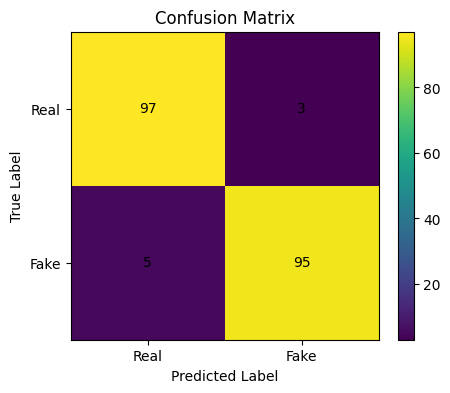

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0,1], ["Real", "Fake"])
plt.yticks([0,1], ["Real", "Fake"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.show()


In [51]:
print(classification_report(
    y_true, y_pred,
    target_names=["Real", "Fake"]
))


              precision    recall  f1-score   support

        Real       0.95      0.97      0.96       100
        Fake       0.97      0.95      0.96       100

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



In [57]:
!apt-get install libportaudio2
!pip install -q sounddevice scipy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 65.3 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Fetched 65.3 kB in 0s (155 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1.1) ...
Setting up libportaudio2:amd64 (19.6.0-1.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libhwloc.so.15 is not a symbolic link

/sbin/ldconfig.real: /usr/local/li

In [60]:
from google.colab import files

## Make a Prediction on a New Uploaded Audio File

In [ ]:
uploaded_new = files.upload()

new_uploaded_filename = None
for fn in uploaded_new.keys():
    new_uploaded_filename = fn
    print(f'User uploaded new file "{new_uploaded_filename}" with length {len(uploaded_new[fn])} bytes')
    break

if new_uploaded_filename:
    prediction_probability_new = predict_audio_class(new_uploaded_filename)

    print(f"\nPrediction probability for '{new_uploaded_filename}' (for 'fake'): {prediction_probability_new:.4f}")

    if prediction_probability_new > 0.5:
        print(f"The model predicts: FAKE audio for '{new_uploaded_filename}'")
    else:
        print(f"The model predicts: REAL audio for '{new_uploaded_filename}'")
else:
    print("No new file was uploaded.")

In [62]:
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving voice-sample.wav to voice-sample.wav
User uploaded file "voice-sample.wav" with length 2320466 bytes


In [63]:
# Assuming the uploaded file is 'voice-sample.wav' as per your output
# If you uploaded a different file, please change 'fn' accordingly.
for fn in uploaded.keys():
    uploaded_filename = fn
    break

# Load the uploaded audio file
input_audio = load_audio(uploaded_filename)
print(f"Loaded audio from '{uploaded_filename}' with shape: {input_audio.shape}")

Loaded audio from 'voice-sample.wav' with shape: torch.Size([420800])


Next, we'll extract the wav2vec embeddings from this audio. The `extract_wav2vec_embedding` function we defined earlier will be used for this.

In [64]:
input_embedding = extract_wav2vec_embedding(uploaded_filename)
print(f"Extracted embedding shape: {input_embedding.shape}")

Extracted embedding shape: (1314, 768)


Now, we'll prepare the embedding for the model and get a prediction. Remember, the model outputs a sigmoid value between 0 and 1, which represents the probability of the audio being 'fake' (class 1). If the probability is below 0.5, it's classified as 'real' (class 0).

In [65]:
# Convert to tensor and add batch dimension
input_tensor = torch.tensor(input_embedding, dtype=torch.float32).unsqueeze(0).to(device)

model.eval() # Set model to evaluation mode
with torch.no_grad():
    prediction = model(input_tensor).squeeze().item()

print(f"Prediction probability (for 'fake'): {prediction:.4f}")

if prediction > 0.5:
    print("The model predicts: FAKE audio")
else:
    print("The model predicts: REAL audio")

Prediction probability (for 'fake'): 0.0000
The model predicts: REAL audio


## Create Prediction Function

### Subtask:
Define a Python function, `predict_audio_class`, that takes an audio file path as input. This function will:
1. Load the audio using `load_audio`.
2. Extract wav2vec embeddings using `extract_wav2vec_embedding`.
3. Convert the embeddings to a PyTorch tensor and move it to the correct device.
4. Pass the tensor through the trained `model` to get a prediction.
5. Return the prediction probability (for 'fake').


**Reasoning**:
To complete the subtask, I will define the `predict_audio_class` function as instructed, incorporating the audio loading, embedding extraction, tensor conversion, and model prediction steps.



In [66]:
def predict_audio_class(audio_file_path):
    # 1. & 2. Load audio and extract wav2vec embeddings
    embedding = extract_wav2vec_embedding(audio_file_path)

    # 3. Convert embeddings to a PyTorch tensor and add batch dimension
    input_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)

    # 4. Set model to evaluation mode and perform prediction
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor).squeeze().item()

    # 5. Return the prediction probability
    return prediction

print("Function `predict_audio_class` defined.")

Function `predict_audio_class` defined.


**Reasoning**:
Now that the `predict_audio_class` function is defined, I will call it with the previously uploaded audio file 'voice-sample.wav' and print the prediction results to fulfill the rest of the subtask.



In [67]:
uploaded_filename = 'voice-sample.wav'
prediction_probability = predict_audio_class(uploaded_filename)

print(f"Prediction probability for '{uploaded_filename}' (for 'fake'): {prediction_probability:.4f}")

if prediction_probability > 0.5:
    print(f"The model predicts: FAKE audio for '{uploaded_filename}'")
else:
    print(f"The model predicts: REAL audio for '{uploaded_filename}'")

Prediction probability for 'voice-sample.wav' (for 'fake'): 0.0000
The model predicts: REAL audio for 'voice-sample.wav'


### Saving the model

In [69]:
MODEL_PATH = "/content/bilstm_wav2vec_real_fake.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "input_dim": 768,
    "hidden_dim": 128,
    "num_layers": 2
}, MODEL_PATH)

print("✅ Model saved at:", MODEL_PATH)


✅ Model saved at: /content/bilstm_wav2vec_real_fake.pth


In [70]:
!mkdir audio-deepfake-detection


In [77]:
%cd /content
!zip -r audio-deepfake-detection.zip audio-deepfake-detection



/content
  adding: audio-deepfake-detection/ (stored 0%)


In [78]:
!ls -lh audio-deepfake-detection.zip


-rw-r--r-- 1 root root 200 Dec 14 05:38 audio-deepfake-detection.zip
